This is an exploratory notebook for the modeling of dog breed recognition

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from helper_functions import (clustering, find_cluster, top_k_accuracy, 
                              image_preprocessing,
                              learning_curve, 
                              feature_engineering)
from scipy.io import loadmat
from xml.dom import minidom
from skimage import filters
import os
import pdb 
import seaborn as sns
sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#some flags
crossval = True
l_clustering = True
dir_path = os.getcwd()

# Load data

In [3]:
train_list = loadmat('./lists/train_list.mat')
test_list = loadmat('./lists/test_list.mat')

In [4]:
import re

def find_dogbreed(file_str, delimiter="-|/"):
    return re.split("-|/",file_str)[1]

In [5]:
file_list_train = [entry.item() for entry in train_list["file_list"].flatten()]
label_list_train = [entry.item() for entry in train_list["labels"]]
annot_list_train = [entry.item() for entry in train_list['annotation_list'].flatten()]

In [6]:
df_train = pd.DataFrame(
    list(zip(label_list_train, file_list_train, annot_list_train)),
    columns=["LABELS", "PATH", "ANNOTATION"])
df_train["BREED"] = df_train.PATH.apply(find_dogbreed)
df_y_train = pd.get_dummies(df_train.LABELS)

In [7]:
df_train.sample(10, random_state=42)

LABELS                                               PATH  \
1935      20       n02090721-Irish_wolfhound/n02090721_3398.jpg   
6494      65      n02101388-Brittany_spaniel/n02101388_2522.jpg   
1720      18                 n02090379-redbone/n02090379_91.jpg   
9120      92                 n02108089-boxer/n02108089_4865.jpg   
360        4             n02086079-Pekinese/n02086079_21103.jpg   
9663      97        n02109525-Saint_Bernard/n02109525_16100.jpg   
5277      53  n02098286-West_Highland_white_terrier/n0209828...   
8546      86             n02107142-Doberman/n02107142_11757.jpg   
2221      23          n02091244-Ibizan_hound/n02091244_2871.jpg   
4617      47       n02097130-giant_schnauzer/n02097130_3385.jpg   

                                             ANNOTATION  \
1935           n02090721-Irish_wolfhound/n02090721_3398   
6494          n02101388-Brittany_spaniel/n02101388_2522   
1720                     n02090379-redbone/n02090379_91   
9120                     n02108089-boxer/n02108089_4865   
360                  n02086079-Pekinese/n02086079_21103   
9663            n02109525-Saint_Bernard/n02109525_16100   
5277  n02098286-West_Highland_white_terrier/n0209828...   
8546                 n02107142-Doberman/n02107142_11757   
2221              n02091244-Ibizan_hound/n02091244_2871   
4617           n02097130-giant_schnauzer/n02097130_3385   

                            BREED  
1935              Irish_wolfhound  
6494             Brittany_spaniel  
1720                      redbone  
9120                        boxer  
360                      Pekinese  
9663                Saint_Bernard  
5277  West_Highland_white_terrier  
8546                     Doberman  
2221                 Ibizan_hound  
4617              giant_schnauzer

In [8]:
def img_cropping(parsedXML, img):
    xmin = int(parsedXML.getElementsByTagName('xmin')[0].firstChild.nodeValue)
    ymin = int(parsedXML.getElementsByTagName('ymin')[0].firstChild.nodeValue)
    xmax = int(parsedXML.getElementsByTagName('xmax')[0].firstChild.nodeValue)
    ymax = int(parsedXML.getElementsByTagName('ymax')[0].firstChild.nodeValue)
    
    cropped = img[xmin:xmax,ymin:ymax]
    return cropped

In [9]:
file_list_test = [entry.item() for entry in test_list["file_list"].flatten()]
label_list_test = [entry.item() for entry in test_list["labels"]]
annot_list_test = [entry.item() for entry in test_list['annotation_list'].flatten()]

In [10]:
df_test = pd.DataFrame(
    list(zip(label_list_test, file_list_test, annot_list_test)),
    columns=["LABELS", "PATH", "ANNOTATION"])
df_test["BREED"] = df_test.PATH.apply(find_dogbreed)
df_y_test = pd.get_dummies(df_test.LABELS)

In [11]:
df_test.sample(10, random_state=42)

LABELS                                           PATH  \
4951      66           n02101556-clumber/n02101556_2362.jpg   
4825      64      n02101006-Gordon_setter/n02101006_772.jpg   
6740      97     n02109525-Saint_Bernard/n02109525_6693.jpg   
222        3       n02085936-Maltese_dog/n02085936_1155.jpg   
5746      81           n02106030-collie/n02106030_17285.jpg   
6969     100   n02110185-Siberian_husky/n02110185_13197.jpg   
1084      12            n02088364-beagle/n02088364_6211.jpg   
2758      35   n02094114-Norfolk_terrier/n02094114_2823.jpg   
6458      91       n02108000-EntleBucher/n02108000_1468.jpg   
3459      43  n02096294-Australian_terrier/n02096294_73.jpg   

                                     ANNOTATION               BREED  
4951           n02101556-clumber/n02101556_2362             clumber  
4825      n02101006-Gordon_setter/n02101006_772       Gordon_setter  
6740     n02109525-Saint_Bernard/n02109525_6693       Saint_Bernard  
222        n02085936-Maltese_dog/n02085936_1155         Maltese_dog  
5746           n02106030-collie/n02106030_17285              collie  
6969   n02110185-Siberian_husky/n02110185_13197      Siberian_husky  
1084            n02088364-beagle/n02088364_6211              beagle  
2758   n02094114-Norfolk_terrier/n02094114_2823     Norfolk_terrier  
6458       n02108000-EntleBucher/n02108000_1468         EntleBucher  
3459  n02096294-Australian_terrier/n02096294_73  Australian_terrier

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


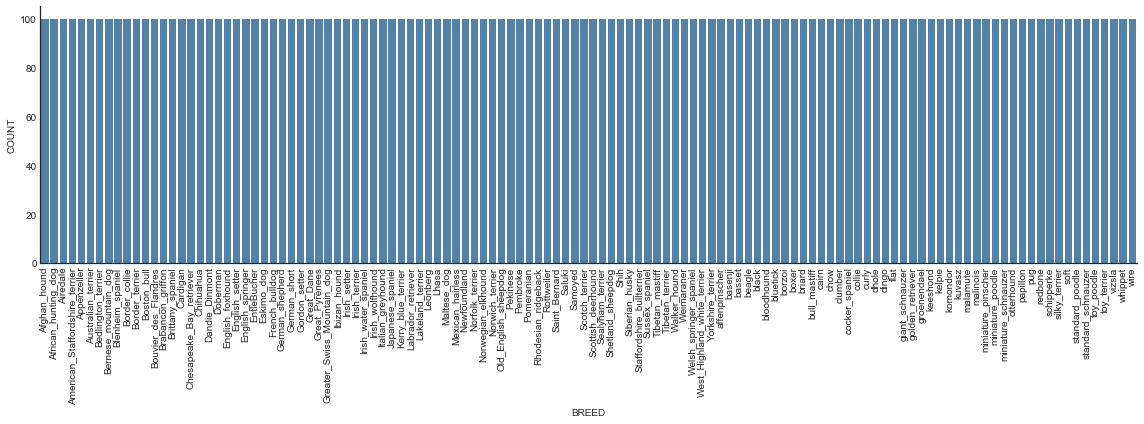

In [12]:
# Sanity check: plot train set distribution 
df_train_count = df_train.groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(df_train_count.index, df_train_count, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_train_count.index,rotation=90)
sns.despine()
#ax.set_title("train set dog breed distribution")
plt.tight_layout()
fig.savefig(dir_path + "/fig/train_set_distrib.pdf")

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


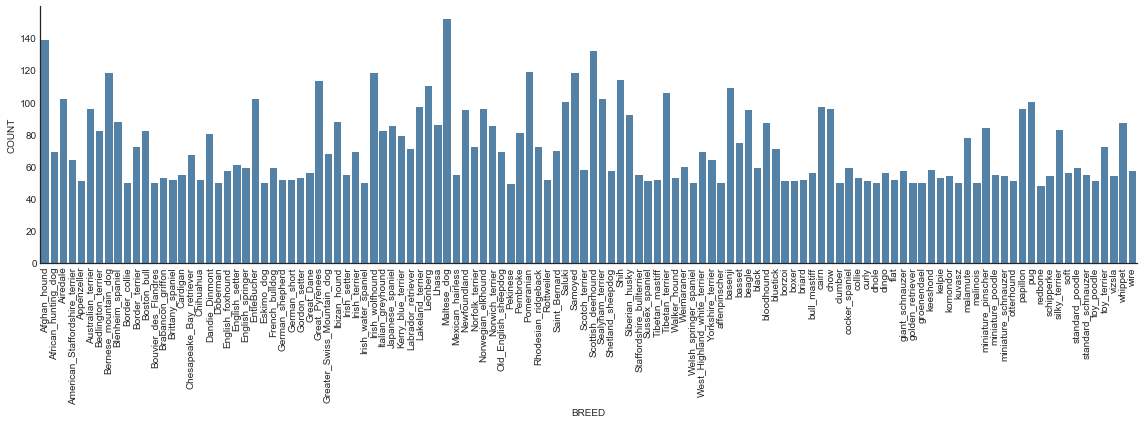

In [13]:
# Sanity check: plot train set distribution 
df_test_count = df_test.groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(df_test_count.index, df_test_count, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_test_count.index,rotation=90)
sns.despine()
#ax.set_title("test set dog breed distribution")
plt.tight_layout()
fig.savefig(dir_path + "/fig/test_set_distrib.pdf")

__Observation:__
- Distribution of dog breed in the training set is uniform
- Distribution of dog breed in the test set is not uniform

# Example of HOG + Daisy + SIFT features

/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


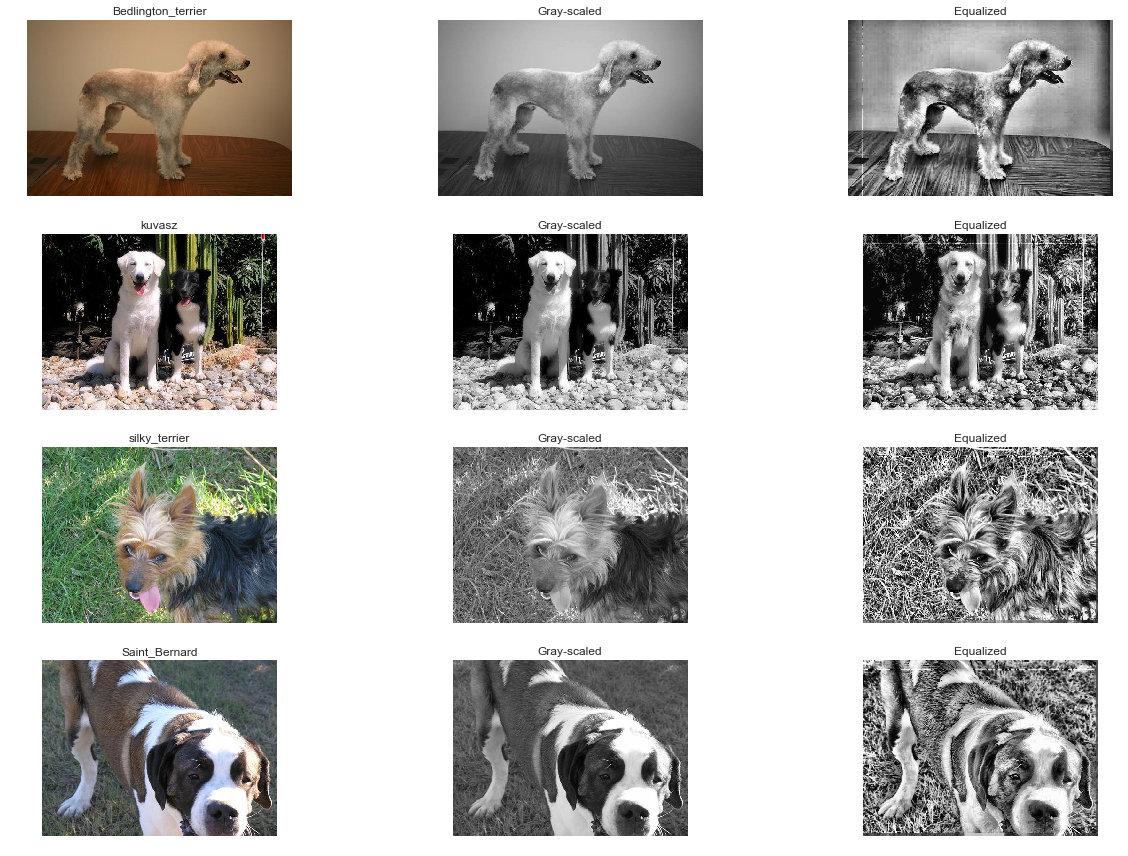

In [14]:
from skimage import exposure
from skimage.io import imread
from skimage.color import rgb2grey
from skimage import filters

index_image = [3083, 7198, 5069, 9659]
images = [[] for i in range(len(index_image))]
preprocessed1 = [[] for i in range(len(index_image))]
preprocessed2 = [[] for i in range(len(index_image))]
#preprocessed3 = [[] for i in range(len(index_image))]


for i, key in enumerate(index_image):
    images[i] = imread("./images/" + df_train.loc[key].PATH)
    preprocessed1[i] = rgb2grey(images[i])
    #preprocessed2[i] = filters.median(preprocessed1[i])
    preprocessed2[i] = exposure.equalize_adapthist(preprocessed1[i], clip_limit=0.03)
    
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
j = 0

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')

    if i % 3 == 0:
        ax.imshow(images[j])
        ax.set_title(df_train.loc[index_image[j]].BREED)
    elif i % 3 == 1:
        ax.imshow(preprocessed1[j], cmap=plt.cm.gray)
        ax.set_title("Gray-scaled")
    elif i % 3 == 2:
        ax.imshow(preprocessed2[j], cmap=plt.cm.gray)
        ax.set_title('Equalized')
        j += 1
    #elif i % 3 == 3:
    #    ax.imshow(preprocessed3[j], cmap=plt.cm.gray)
    #    ax.set_title('Equalized')
        
plt.tight_layout()
fig.savefig(dir_path + "/fig/pre_processed.pdf")

/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


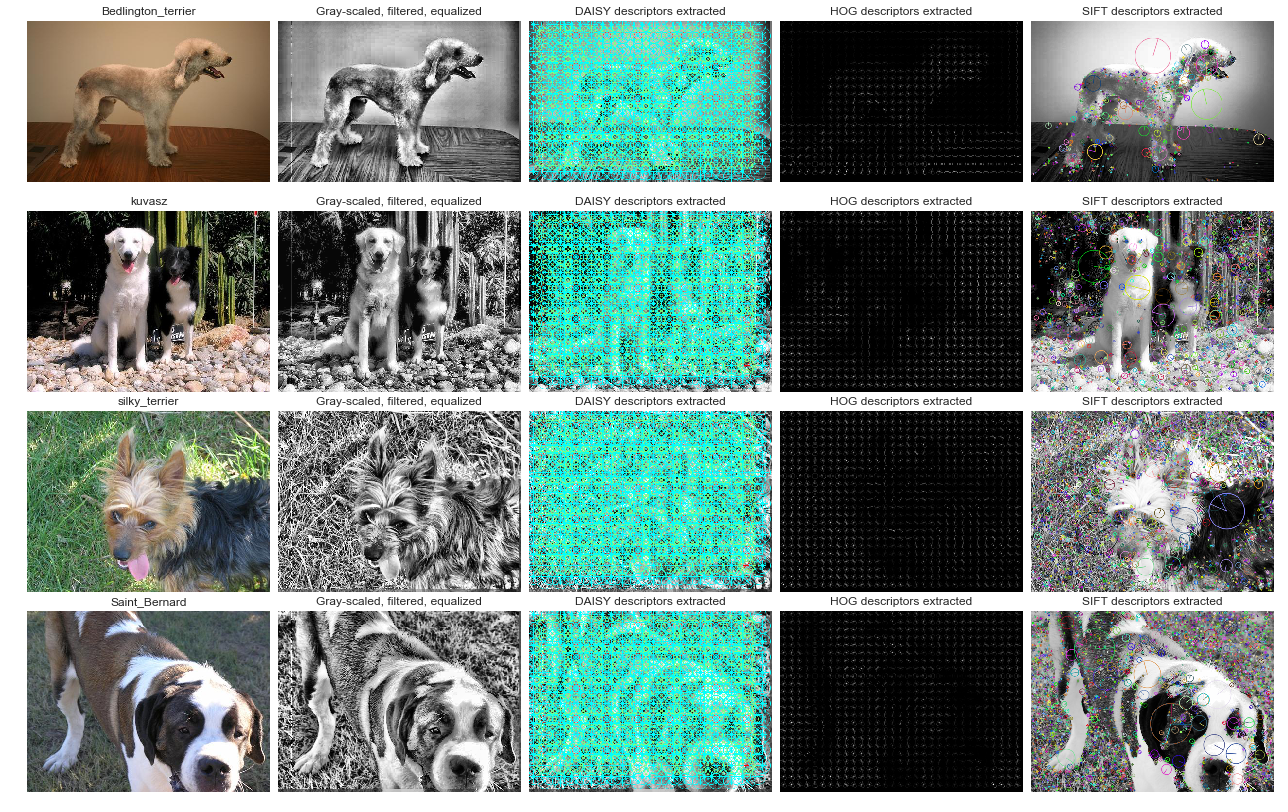

In [15]:
from skimage import exposure
from skimage.io import imread

index_image = [3083, 7198, 5069, 9659]
descs_daisy = [[] for i in range(len(index_image))]
descs_hog = [[] for i in range(len(index_image))]
images_hog = [[] for i in range(len(index_image))]
images_daisy = [[] for i in range(len(index_image))]
images = [[] for i in range(len(index_image))]
preprocessed_images = [[] for i in range(len(index_image))]
descs_SIFT = [[] for i in range(len(index_image))]
images_SIFT = [[] for i in range(len(index_image))]

for i, key in enumerate(index_image):
    images[i] = imread("./images/" + df_train.loc[key].PATH)
    preprocessed_images[i] = image_preprocessing(images[i])
    #img = imread("./images/" + df_train.loc[key].PATH)
    #parsedXML = minidom.parse("./Annotation/"+ df_train.loc[key].ANNOTATION)
    #images[i] = img_cropping(parsedXML, img)
    #images[i] = filters.gaussian(img, multichannel=True)
    #pdb.set_trace()
    output = feature_engineering(images[i], visualize=True)
    descs_hog[i] = output[0][0]
    images_hog[i] = output[0][1]
    descs_daisy[i] = output[1][0]
    images_daisy[i] = output[1][1]
    descs_SIFT[i] = output[2][0]
    images_SIFT[i] = output[2][1]
    
fig, axes = plt.subplots(4, 5, figsize=(18, 12))
j = 0

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')

    if i % 5 == 0:
        ax.imshow(images[j])
        ax.set_title(df_train.loc[index_image[j]].BREED)
    elif i % 5 == 1:
        ax.imshow(preprocessed_images[j], cmap=plt.cm.gray)
        ax.set_title("Gray-scaled, filtered, equalized")
    elif i % 5 == 2:
        ax.imshow(images_daisy[j], cmap=plt.cm.gray)
        descs_num = descs_daisy[j].shape[0] * descs_daisy[j].shape[1]
        ax.set_title('DAISY descriptors extracted')
    elif i % 5 == 3:
        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(images_hog[j], 
                                                        in_range = (0,10))
        ax.imshow(images_hog[j], cmap=plt.cm.gray)
        ax.set_title('HOG descriptors extracted')
    elif i % 5 == 4:
        ax.imshow(images_SIFT[j], cmap=plt.cm.gray)
        ax.set_title('SIFT descriptors extracted')
        # incrementation
        j += 1
plt.tight_layout(h_pad=-5, w_pad = -2)
fig.savefig(dir_path + "/fig/features.pdf")

## BOVW representation
Perform clustering on Daisy features to form a dictionary. A histogram feature (daisy histogram) corresponding to each feature of k-dimensions, k is to be determined.

### Train/test set preparation

In [16]:
from numpy.random import seed, shuffle

# train set
seed(12)
size_train = len(df_train)
n_class_temp = numpy.arange(120)
shuffle(n_class_temp)
n_class = n_class_temp[:20]
n_class_init = 120
init_n_train = size_train/n_class_init # don't change
n_train = [20, 40, 60, 80, 100] # train per class
index_train_samples = [[] for i in range(len(n_train))]

for j in range(len(n_train)):
    # train set indices
    for i in n_class:
        index_train_temp = np.arange((i-1) * init_n_train, i * init_n_train , dtype=int)
        np.random.seed(2)
        np.random.shuffle(index_train_temp)
        index_train_samples[j].extend(index_train_temp[:n_train[j]])
        
# test set indices
n_test_overall = len(index_train_samples[4])#int(.8*len(index_train_samples[0]))
index_test_temp = list(df_test[df_test.LABELS.isin(n_class)].index)
#index_test_temp = list(df_test.filter(items=n_class, axis=1).index)
np.random.shuffle(index_test_temp)
index_test_samples = index_test_temp[:n_test_overall]

## Sanity check
Random sampling of each breed.

__Train set__

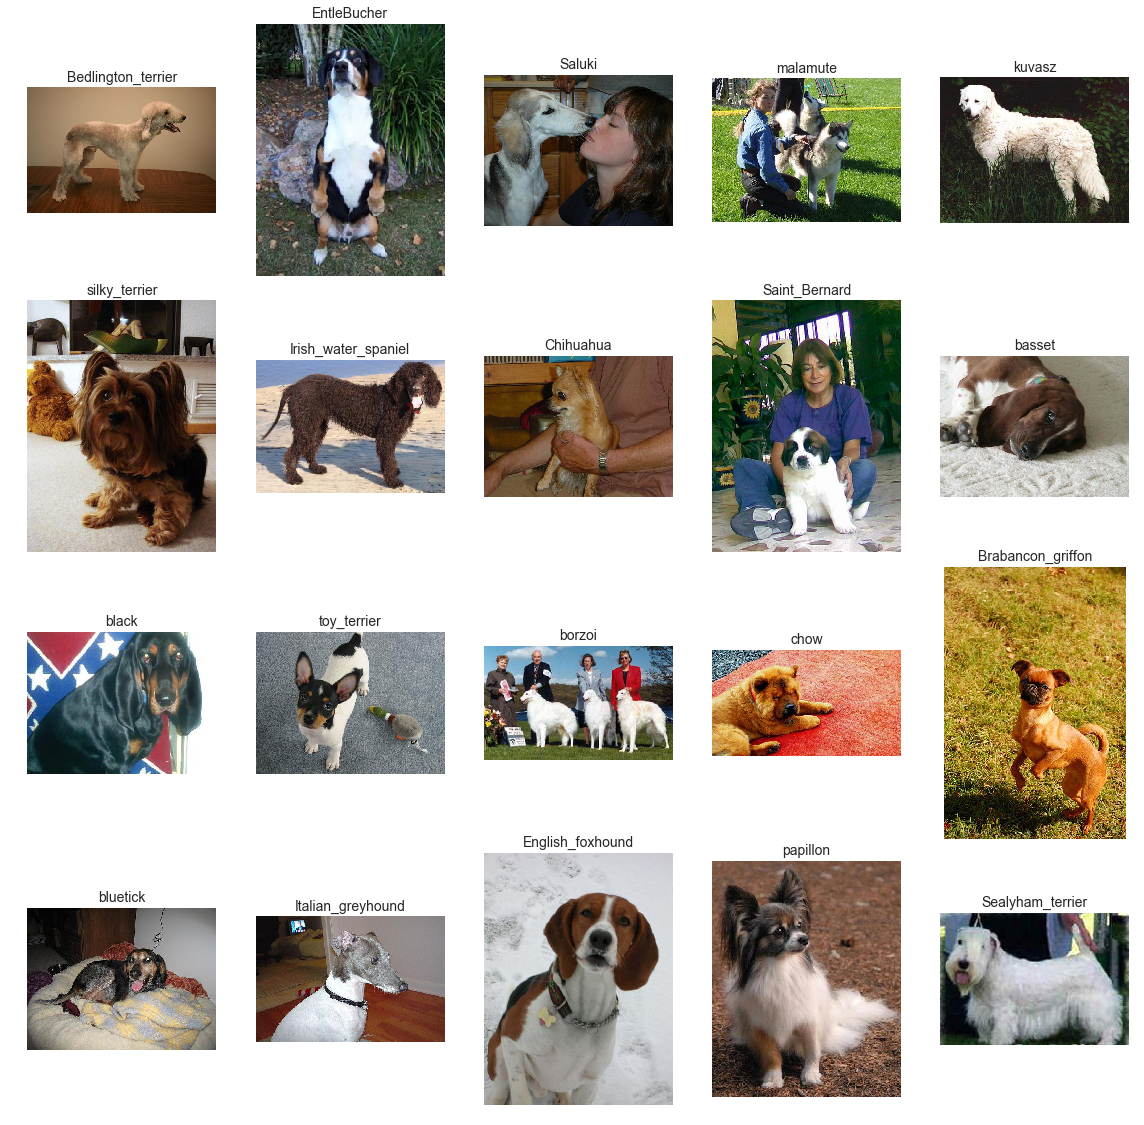

In [17]:
dog_breed = df_train.loc[index_train_samples[0]].drop_duplicates(subset="BREED")
fig, axes = plt.subplots(4,5, figsize=(16,16))
ax = axes.flatten()
counter = 0

for _ , breed in dog_breed.iterrows():
    dog_img = imread("./images/" + breed.PATH)
    #parsedXML = minidom.parse("./Annotation/"+ breed.ANNOTATION)
    #cropped_image = img_cropping(parsedXML, dog_img)
    #filtered_img = filters.gaussian(dog_img, multichannel=True)
    ax[counter].imshow(dog_img)
    ax[counter].set_title(breed.BREED, fontsize=14)
    ax[counter].set_axis_off()
    counter += 1
    
plt.tight_layout()
fig.savefig(dir_path +"/fig/dog_samples.pdf")

__Test set__

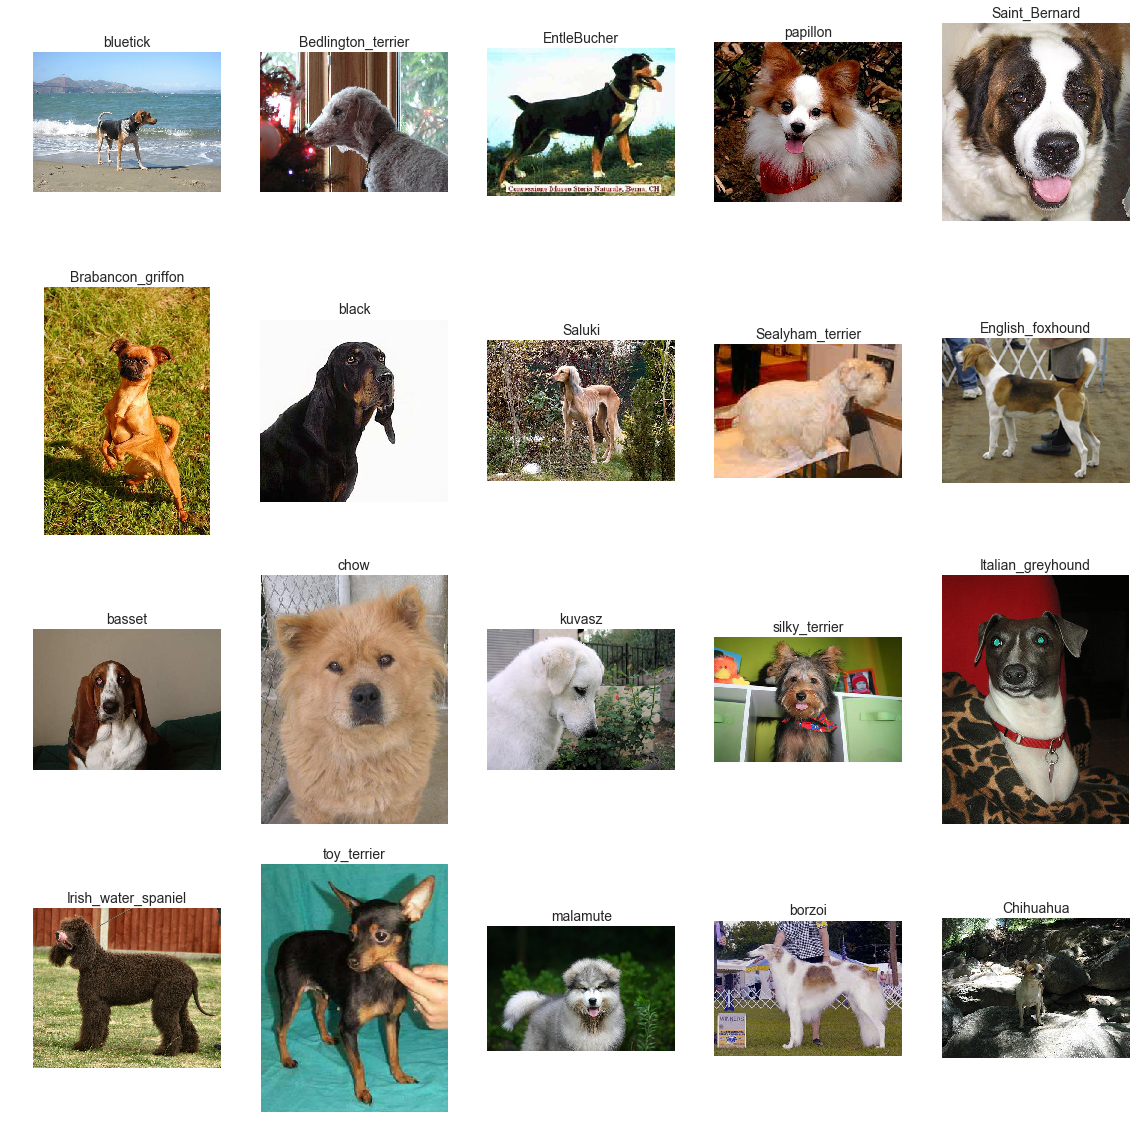

In [18]:
dog_breed_test = df_test.loc[index_test_samples].drop_duplicates(subset="BREED")
fig, axes = plt.subplots(4,5, figsize=(16,16))
ax = axes.flatten()
counter = 0

for _ , breed in dog_breed_test.iterrows():
    dog_img = imread("./images/" + breed.PATH)
    #parsedXML = minidom.parse("./Annotation/"+ breed.ANNOTATION)
    #cropped_image = img_cropping(parsedXML, dog_img)
    #filtered_img = filters.gaussian(dog_img, multichannel=True)
    ax[counter].imshow(dog_img)
    ax[counter].set_title(breed.BREED, fontsize=14)
    ax[counter].set_axis_off()
    counter += 1

plt.tight_layout()
fig.savefig(dir_path + "/fig/test_dog_samples.pdf")

__Observation__:
- Selected dog breeds are rather distinct

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


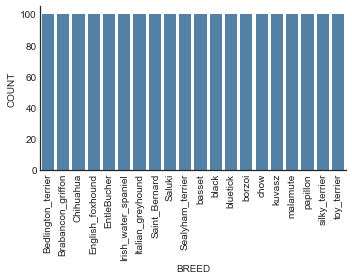

In [19]:
# Sanity check: plot train set distribution 
df_train_count_resampled = df_train.loc[index_train_samples[4]].groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(df_train_count_resampled.index, df_train_count_resampled, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_train_count_resampled.index,rotation=90)
sns.despine()
#ax.set_title("train set dog breed distribution")
plt.tight_layout()
fig.savefig(dir_path +"/fig/train_distrib_resampled.pdf")

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


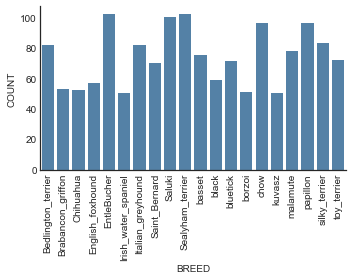

In [20]:
# Sanity check: plot train set distribution 
df_test_count_resampled = df_test.loc[index_test_samples].groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(df_test_count_resampled.index, df_test_count_resampled, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_test_count_resampled.index,rotation=90)
sns.despine()
#ax.set_title("train set dog breed distribution")
plt.tight_layout()
fig.savefig(dir_path +"/fig/test_distrib_resampled.pdf")

# Feature Engineering

In [21]:
hog_feat_list = [[] for i in range(len(n_train))]
daisy_feat_list = [[] for i in range(len(n_train))]
sift_feat_list = [[] for i in range(len(n_train))]
y_train = [[] for i in range(len(n_train))]
train_features = [defaultdict(list) for i in range(len(n_train))]
test_features = defaultdict(list)

print("Feature engineering for the train set...")

for j in range(len(n_train)):
    for i, key in tqdm(enumerate(index_train_samples[j])):
        dog_img = imread("./images/" + df_train.loc[key].PATH)
        #parsedXML = minidom.parse("./Annotation/"+ df_train.loc[key].ANNOTATION)
        #cropped_image = img_cropping(parsedXML, dog_img)
        #filtered_img = filters.gaussian(dog_img, multichannel=True)
        
        output_features = feature_engineering(dog_img)
        train_features[j][key] = output_features
        hog_feat_list[j] = hog_feat_list[j] + list(output_features[0])
        daisy_feat_list[j] = daisy_feat_list[j] + list(output_features[1])
        sift_feat_list[j] = sift_feat_list[j] + list(output_features[2])
       
    print('Total Daisy descriptors (train):', len(daisy_feat_list[j]))
    print('Total SIFT descriptors (train):', len(sift_feat_list[j]))
    print('Total HOG descriptors (train):', len(hog_feat_list[j]))
    
    y_train[j] = df_train.loc[index_train_samples[j]].LABELS

#test set
#counter_test = 0
print("Feature engineering for the test set...")
for i, key in tqdm(enumerate(index_test_samples)):
    dog_img = imread("./images/" + df_test.loc[key].PATH)
    #parsedXML = minidom.parse("./Annotation/"+ df_test.loc[key].ANNOTATION)
    #cropped_image = img_cropping(parsedXML, dog_img)
    #filtered_img = filters.gaussian(dog_img, multichannel=True)
    #try:
    output_features = feature_engineering(dog_img)
    test_features[key] = output_features
    #except (ValueError, IndexError, TypeError) as e:
    #   counter_test +=1
#print(counter_test)
y_test = df_test.loc[index_test_samples].LABELS

0it [00:00, ?it/s]

Feature engineering for the train set...


/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
400it [04:48,  1.39it/s]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 52659
Total SIFT descriptors (train): 709388
Total HOG descriptors (train): 2106560


800it [10:04,  1.32it/s]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 103797
Total SIFT descriptors (train): 1347104
Total HOG descriptors (train): 4156104


1200it [16:31,  1.21it/s]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 164874
Total SIFT descriptors (train): 2114808
Total HOG descriptors (train): 6536104


1600it [21:26,  1.24it/s]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 219164
Total SIFT descriptors (train): 2795024
Total HOG descriptors (train): 8692160


2000it [27:56,  1.19it/s]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 275425
Total SIFT descriptors (train): 3500966
Total HOG descriptors (train): 10906656
Feature engineering for the test set...


1481it [19:08,  1.29it/s]


# Model Training
## Using only SIFT descriptors
### Study of performance vs number of samples
We limit our study to only 20 classes to curtail calculation. Logistic regression is used as the model to have a ballpark estimate of the performance. The number of clusters for daisy descriptors is fixed to 1000, will be fine tuned in the following studies.

In [22]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

# we fix the cluster number to 1000, will be fine tuned in the following
# studies
k_sift = 1000
train_scores = [[] for i in range(len(n_train))]
test_scores = [[] for i in range(len(n_train))]
parameters = {'C': np.logspace(-3, 3, 7)}

for j in range(len(n_train)):

    print('Total SIFT descriptors (train):', len(sift_feat_list[j]))

    X_train = []
    X_test = []

    print("Processing k=%d" % k_sift)
    kmeans = clustering(sift_feat_list[j], k_sift)

    for key, features in train_features[j].items():
        bovw_feature = find_cluster(kmeans, features[2])
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_test = find_cluster(kmeans, features[2])
        X_test.append(bovw_feature_test)

    print("Training...")
   
    svc = LinearSVC(multi_class="ovr")
    clf = GridSearchCV(svc, parameters, scoring='accuracy')
    #clf = OneVsRestClassifier(LogisticRegressionCV(dual=False))
    #clf = OneVsRestClassifier(CalibratedClassifierCV(SVC(C=1)))
    clf.fit(X_train, y_train[j])
    #print("(CV) Best score:", clf.best_score_)
    print("(CV) Mode best C:", clf.best_estimator_.C)

    print("Prediction...")
    y_pred_train = clf.predict(np.array(X_train))
    y_pred_test = clf.predict(np.array(X_test))
    train_score = accuracy_score(y_train[j], y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    print('Overall accuracy (train):', train_score)
    print('Overall accuracy (test):', test_score)
    train_scores[j] = train_score
    test_scores[j] = test_score

Total SIFT descriptors (train): 709388
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.915
Overall accuracy (test): 0.1586765698852127
Total SIFT descriptors (train): 1347104
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.84875
Overall accuracy (test): 0.1937879810938555
Total SIFT descriptors (train): 2114808
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.7841666666666667
Overall accuracy (test): 0.2113436866981769
Total SIFT descriptors (train): 2795024
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.7475
Overall accuracy (test): 0.22822417285617827
Total SIFT descriptors (train): 3500966
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.69
Overall accuracy (test): 0.24442943956785956


In [23]:
df_n_samples = pd.DataFrame(list(zip(n_train,train_scores,test_scores)), columns=["SAMPLES","TRAIN", "TEST"])

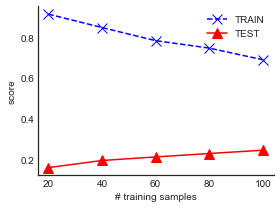

In [255]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df_n_samples.SAMPLES, df_n_samples.TRAIN, marker="x", markersize=10, 
        label="TRAIN", linestyle = "--", color="blue")
ax.plot(df_n_samples.SAMPLES, df_n_samples.TEST, marker="^", markersize=10, 
        label="TEST", linestyle = "solid", color="red")
ax.legend(loc='best')
ax.set_xlabel("# training samples")
ax.set_ylabel("score")
sns.despine()
plt.tight_layout()
fig.savefig(dir_path + "/fig/train-test.pdf")

__Observation__:
- We observe a tendency of the gap closing between the train score and the test score, however the number of training samples is not high enough to close the gap. More samples per class are needed to be able to improve the performance.
- We retain here 100 samples per class, and with a regularisation term C=0.1.

### Determing the optimal number of clusters for SIFT descriptors

In [25]:
index_op_sample = 4
unique_y = df_train.loc[index_train_samples[index_op_sample]].LABELS.unique()
label2class = dict()
invertlabel2class = dict()

for i, j in enumerate(unique_y):
    label2class[j] = i
    invertlabel2class[i] = j

label2breed = dict()
df_label_breed = df_train.loc[index_train_samples[index_op_sample]][[
    "LABELS", "BREED"
]].drop_duplicates()

for k, v in df_label_breed.iterrows():
    label2breed[v.LABELS] = v.BREED

In [252]:
#save dictionaries
import pickle

f_label2breed = open(dir_path +'/db/label2breed.p', 'wb')
f_invertlabel2class = open(dir_path +'/db/invertlabel2class.p', 'wb')

pickle.dump(label2breed, f_label2breed)
pickle.dump(invertlabel2class,  f_invertlabel2class)

In [26]:
y_train_c = df_train.loc[index_train_samples[index_op_sample]].LABELS.replace(label2class)
y_test = df_test.loc[index_test_samples].LABELS.replace(label2class)

In [27]:
from sklearn.model_selection import KFold
#l_clustering = True
if l_clustering:
    C = 0.1
    index_op_sample = 4
    n_splits = 3
    train_features_c = train_features[index_op_sample]
    n_clusters = np.logspace(2, 3.5, 6, dtype=int32)
    train_scores_clusters = [[] for i in range(len(n_clusters))]
    test_scores_clusters = [[] for i in range(len(n_clusters))]
    cv_scores_clusters = [[]for i in range(len(n_clusters))]

    for j, k in enumerate(n_clusters):
        # training set
        X_train = []
        X_test = []

        print("Processing k=%d" %k )
        kmeans = clustering(sift_feat_list[index_op_sample], k)

        for key, features in train_features_c.items():
            bovw_feature = find_cluster(kmeans, features[2])
            X_train.append(bovw_feature)

        for key, features in test_features.items():
            bovw_feature_test = find_cluster(kmeans, features[2])
            X_test.append(bovw_feature_test)

        print("Training (Cross Validation)...")
        clf = LinearSVC(multi_class="ovr", C=C)

        kf = KFold(n_splits=n_splits)
        X_temp = np.array(X_train)
        y_temp = np.array(y_train_c)

        for train_index, test_index in kf.split(X_temp):
            clf.fit(X_temp[train_index,:], y_temp[train_index])

            # training
            y_train_pred = clf.predict(X_temp[train_index,:])
            train_scores_clusters[j].append(accuracy_score(y_temp[train_index], y_train_pred))

            # cross validation
            y_cv_pred = clf.predict(X_temp[test_index,:])
            cv_scores_clusters[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

            # test
            y_test_pred = clf.predict(np.array(X_test))
            test_scores_clusters[j].append(accuracy_score(y_test, y_test_pred))

        train_score = np.mean(train_scores_clusters[j])
        test_score = np.mean(test_scores_clusters[j])

        print('Overall accuracy (train):', train_score)
        print('Overall accuracy (test):', test_score)

Processing k=100
Training (Cross Validation)...
Overall accuracy (train): 0.33024935394268357
Overall accuracy (test): 0.16250281341435968
Processing k=199
Training (Cross Validation)...
Overall accuracy (train): 0.4142538633159039
Overall accuracy (test): 0.17938329957236102
Processing k=398
Training (Cross Validation)...
Overall accuracy (train): 0.5100032504377968
Overall accuracy (test): 0.18118388476254785
Processing k=794
Training (Cross Validation)...
Overall accuracy (train): 0.648001205698726
Overall accuracy (test): 0.1933378347963088
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.7970015367410069
Overall accuracy (test): 0.19671393202790907
Processing k=3162
Training (Cross Validation)...
Overall accuracy (train): 0.9030001128468023
Overall accuracy (test): 0.1973891514742291


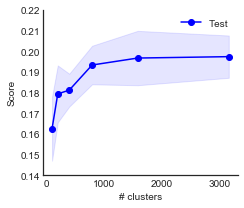

In [113]:
# Plot
if l_clustering:
    fig, ax = plt.subplots(figsize=(3.5, 3))
    ax = learning_curve(n_clusters, ax, test_scores = test_scores_clusters)
    ax.set_ylim(0.14, 0.22)
    sns.despine()
    plt.tight_layout()
    fig.savefig(dir_path + "/fig/test_score_sift.pdf")

__Observation__:
- From cluster number>800 onwards, the test score is relatively stable, can be estimated useing the elbow method as well. So we choose cluster number = 800.

In [29]:
if l_clustering:
    df_n_clusters = pd.DataFrame(
        list(zip(n_clusters, np.mean(train_scores_clusters, axis=1),
                np.mean(test_scores_clusters, axis=1))),
        columns=["# CLUSTER", "TRAIN", "TEST"])
    df_n_clusters

## Using Daisy descriptors only
### Determining the right number of clusters for Daisy descriptors

In [30]:
if l_clustering:
    train_scores_clusters_daisy = [[] for i in range(len(n_clusters))]
    test_scores_clusters_daisy = [[] for i in range(len(n_clusters))]
    cv_scores_clusters_daisy = [[]for i in range(len(n_clusters))]

    for j, k in enumerate(n_clusters):
        # training set
        X_train = []
        X_test = []

        print("Processing k=%d" %k )
        kmeans = clustering(daisy_feat_list[index_op_sample], k)

        for key, features in train_features_c.items():
            bovw_feature = find_cluster(kmeans, features[1])
            X_train.append(bovw_feature)

        for key, features in test_features.items():
            bovw_feature_test = find_cluster(kmeans, features[1])
            X_test.append(bovw_feature_test)

        print("Training (Cross Validation)...")
        clf = LinearSVC(multi_class="ovr", C=C)

        kf = KFold(n_splits=n_splits)
        X_temp = np.array(X_train)
        y_temp = np.array(y_train_c)

        for train_index, test_index in kf.split(X_temp):
            clf.fit(X_temp[train_index,:], y_temp[train_index])

            # training
            y_train_pred = clf.predict(X_temp[train_index,:])
            train_scores_clusters_daisy[j].append(accuracy_score(y_temp[train_index], y_train_pred))

            # cross validation
            y_cv_pred = clf.predict(X_temp[test_index,:])
            cv_scores_clusters_daisy[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

            # test
            y_test_pred = clf.predict(np.array(X_test))
            test_scores_clusters_daisy[j].append(accuracy_score(y_test, y_test_pred))

        train_score = np.mean(train_scores_clusters_daisy[j])
        test_score = np.mean(test_scores_clusters_daisy[j])

        print('Overall accuracy (train):', train_score)
        print('Overall accuracy (test):', test_score)

Processing k=100
Training (Cross Validation)...
Overall accuracy (train): 0.33674835500479317
Overall accuracy (test): 0.1327931577762773
Processing k=199
Training (Cross Validation)...
Overall accuracy (train): 0.4375004920645454
Overall accuracy (test): 0.1354940355615575
Processing k=398
Training (Cross Validation)...
Overall accuracy (train): 0.5685040075611107
Overall accuracy (test): 0.13819491334683773
Processing k=794
Training (Cross Validation)...
Overall accuracy (train): 0.7305027156339311
Overall accuracy (test): 0.14697276614899843
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.8632514200514146
Overall accuracy (test): 0.15282466801710556
Processing k=3162
Training (Cross Validation)...
Overall accuracy (train): 0.9405025544242133
Overall accuracy (test): 0.15507539950483906


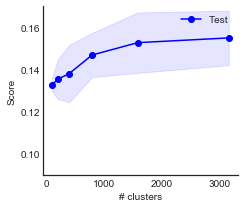

In [111]:
# Plot
if l_clustering:
    fig, ax = plt.subplots(figsize=(3.5, 3))
    ax = learning_curve(n_clusters, ax, test_scores = test_scores_clusters_daisy)
    ax.set_ylim(0.09, 0.17)
    sns.despine()
    plt.tight_layout()
    fig.savefig(dir_path + "/fig/test_score_daisy.pdf")

In [32]:
if l_clustering:
    df_n_clusters_daisy = pd.DataFrame(
        list(
            zip(n_clusters, np.mean(train_scores_clusters_daisy, axis=1),
                np.mean(test_scores_clusters_daisy, axis=1))),
        columns=["# CLUSTER", "TRAIN", "TEST"])
    df_n_clusters_daisy

## Using HOG descriptors only
### Determining the right number of clusters for HOG descriptors

In [33]:
if l_clustering:
    n_clusters_hog = np.logspace(3, 4, 6, dtype=int32)
    train_scores_clusters_hog = [[] for i in range(len(n_clusters_hog))]
    test_scores_clusters_hog = [[] for i in range(len(n_clusters_hog))]
    cv_scores_clusters_hog = [[]for i in range(len(n_clusters_hog))]

    for j, k in enumerate(n_clusters_hog):
        # training set
        X_train = []
        X_test = []

        print("Processing k=%d" %k )
        kmeans = clustering(np.reshape(hog_feat_list[index_op_sample], (-1,1)), k)

        for key, features in train_features_c.items():
            bovw_feature = find_cluster(kmeans, features[0].reshape(-1,1))
            X_train.append(bovw_feature)

        for key, features in test_features.items():
            bovw_feature_test = find_cluster(kmeans, features[0].reshape(-1,1))
            X_test.append(bovw_feature_test)

        print("Training (Cross Validation)...")
        clf = LinearSVC(multi_class="ovr", C=C)

        kf = KFold(n_splits=n_splits)
        X_temp = np.array(X_train)
        y_temp = np.array(y_train_c)

        for train_index, test_index in kf.split(X_temp):
            clf.fit(X_temp[train_index,:], y_temp[train_index])

            # training
            y_train_pred = clf.predict(X_temp[train_index,:])
            train_scores_clusters_hog[j].append(accuracy_score(y_temp[train_index], y_train_pred))

            # cross validation
            y_cv_pred = clf.predict(X_temp[test_index,:])
            cv_scores_clusters_hog[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

            # test
            y_test_pred = clf.predict(np.array(X_test))
            test_scores_clusters_hog[j].append(accuracy_score(y_test, y_test_pred))

        train_score = np.mean(train_scores_clusters_hog[j])
        test_score = np.mean(test_scores_clusters_hog[j])

        print('Overall accuracy (train):', train_score)
        print('Overall accuracy (test):', test_score)

Processing k=1000
Training (Cross Validation)...
Overall accuracy (train): 0.497756185673105
Overall accuracy (test): 0.08845374746792707
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.636504515934081
Overall accuracy (test): 0.09227999099707405
Processing k=2511
Training (Cross Validation)...
Overall accuracy (train): 0.737752841508728
Overall accuracy (test): 0.09385550303848751
Processing k=3981
Training (Cross Validation)...
Overall accuracy (train): 0.8342496043801054
Overall accuracy (test): 0.09273013729462075
Processing k=6309
Training (Cross Validation)...
Overall accuracy (train): 0.8854989234565013
Overall accuracy (test): 0.09925725860904794
Processing k=10000
Training (Cross Validation)...
Overall accuracy (train): 0.914497552424088
Overall accuracy (test): 0.10443394103083502


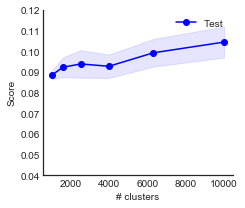

In [112]:
# Plot
if clustering:
    fig, ax = plt.subplots(figsize=(3.5, 3))
    ax = learning_curve(n_clusters_hog, ax, test_scores = test_scores_clusters_hog)
    ax.set_ylim(0.04, 0.12)
    plt.tight_layout()
    sns.despine()
    fig.savefig(dir_path + "/fig/test_score_hog.pdf")

In [85]:
if l_clustering: 
    df_n_clusters_hog = pd.DataFrame(
        list(
            zip(n_clusters_hog,
                np.mean(train_scores_clusters_hog, axis=1),
                np.mean(test_scores_clusters_hog, axis=1))),
        columns=["# CLUSTER", "TRAIN", "TEST"])
    
    print(df_n_clusters_hog)

   # CLUSTER     TRAIN      TEST
0       1000  0.497756  0.088454
1       1584  0.636505  0.092280
2       2511  0.737753  0.093856
3       3981  0.834250  0.092730
4       6309  0.885499  0.099257
5      10000  0.914498  0.104434


In [88]:

def learning_curve(n_clusters, ax, train_scores = None, test_scores = None):
    """
    plot learning curve

    Parameters:
    -----------
    train_scores: array_like
        train_scores
    test_scores: array_like
        test_scores
    ax: plt axis object
        plotting axis

    Returns:
    --------
    ax: plt axis object
    """
    
    if train_scores is not None:
        train_scores_mean = np.array([np.mean(v) for v in train_scores])
        train_scores_std = np.array([np.std(v) for v in train_scores])
        ax.fill_between(n_clusters, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
        ax.plot(n_clusters, train_scores_mean, 'o-', color="r", label="Training")
    
    if test_scores is not None:
        test_scores_mean = np.array([np.mean(v) for v in test_scores])
        test_scores_std = np.array([np.std(v) for v in test_scores])
        ax.fill_between(n_clusters, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
        ax.plot(n_clusters, test_scores_mean, 'o-', color="b", label="Test")
    #cv_scores_mean = np.array([np.mean(v) for v in cv_scores])
    #cv_scores_std = np.array([np.std(v) for v in cv_scores])

   
    #ax.fill_between(n_clusters, cv_scores_mean - cv_scores_std,
    #                     cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
   
   
    #ax.plot(n_clusters, cv_scores_mean, 'o-', color="g",
    #             label="Cross-validation")
    
    ax.legend(loc='best')
    ax.set_xlabel("# clusters")
    ax.set_ylabel("Score")

    return ax

## Combination of SIFT + DAISY + HOG descriptors

In [204]:
from sklearn.calibration import CalibratedClassifierCV
crossval = False
if True:
    k_sift = 800 # number of clusters
    k_daisy = 1600
    index_op_sample = 4
    train_features_c = train_features[index_op_sample]
    C = 0.1
    k_hog = 2500 # number of clusters
    parameters = {'C': np.logspace(-3, 3, 7)}
    X_train = []
    X_test = []

    # Clustering
    kmeans_hog = clustering(np.reshape(hog_feat_list[index_op_sample], (-1,1)), k_hog)
    kmeans_sift = clustering(sift_feat_list[index_op_sample], k_sift)
    kmeans_daisy = clustering(daisy_feat_list[index_op_sample], k_daisy)

    for key, features in train_features_c.items():
        bovw_feature_hog = find_cluster(kmeans_hog, np.reshape(features[0],(-1,1)))
        bovw_feature_daisy = find_cluster(kmeans_daisy, features[1])
        bovw_feature_sift = find_cluster(kmeans_sift, features[2])
        bovw_feature = bovw_feature_sift + bovw_feature_daisy + bovw_feature_hog
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_hog = find_cluster(kmeans_hog,  np.reshape(features[0],(-1,1)))
        bovw_feature_daisy = find_cluster(kmeans_daisy, features[1])
        bovw_feature_sift = find_cluster(kmeans_sift, features[2])
        bovw_feature = bovw_feature_sift + bovw_feature_daisy + bovw_feature_hog
        X_test.append(bovw_feature)
    
print("Training (Cross Validation)...")

if crossval:
    svc =  LinearSVC(multi_class="ovr")
    clf_svm = GridSearchCV(svc, parameters, scoring='accuracy')
    print(clf_svm.best_params_)
else:
    clf_svm =  CalibratedClassifierCV(LinearSVC(multi_class="ovr", C=C))
    
clf_svm.fit(X_train, y_train_c)

print("Prediction...")
y_pred_train = clf_svm.predict(np.array(X_train))
y_pred_test = clf_svm.predict(np.array(X_test))
train_score_svm = accuracy_score(y_train_c, y_pred_train)
test_score_svm = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_svm)
print('Overall accuracy (test):', test_score_svm)

Training (Cross Validation)...
Prediction...
Overall accuracy (train): 0.9545
Overall accuracy (test): 0.28291694800810263


In [205]:
# Save models
from sklearn.externals import joblib
import os

filename = os.getcwd() + '/db/svm_linear.sav'
joblib.dump(clf_svm, filename)

filename_kmeans_hog = os.getcwd() + '/db/kmeans_hog.sav'
joblib.dump(kmeans_hog, filename_kmeans_hog )

filename_kmeans_sift = os.getcwd() + '/db/kmeans_sift.sav'
joblib.dump(kmeans_sift, filename_kmeans_sift )

filename_kmeans_daisy = os.getcwd() + '/db/kmeans_daisy.sav'
joblib.dump(kmeans_daisy, filename_kmeans_daisy )

['/Users/pmlee/Documents/CAPGemini_OpenClassroom/OpenClassrooms_Patrick_Lee/Assignment6/db/kmeans_daisy.sav']

## Visualization with reduced dimension algorithms
### T-SNE

In [211]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_sampled = X_train#[::2]
y_sampled = y_train_c#[::2]
X_scaled = StandardScaler().fit_transform(X_sampled)

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, init='pca')
X_tsne = tsne.fit_transform(X_scaled)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


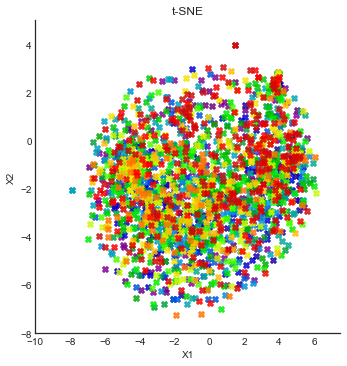

In [226]:
X1_tsne, X2_tsne = list(zip(*X_tsne))
df_tsne = pd.DataFrame(
    [X1_tsne, X2_tsne, y_sampled],
    index=["X1", "X2", "labels"]).T

lm = sns.lmplot(
    x="X1",
    y="X2",
    hue="labels",
    data=df_tsne,
    fit_reg=False,
    legend=False,
    markers="X",
    palette="spectral", size=5)
lm.set(title=("t-SNE"), ylim=(-8,5), xlim=(-10,7.5))

#fig = lm.get_figure()
lm.savefig(dir_path +"/fig/tsne.pdf")

### LDA

In [213]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis( n_components=2)
X_lda = lda.fit_transform(X_scaled, y_sampled)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/pmlee/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/Users/pmlee/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


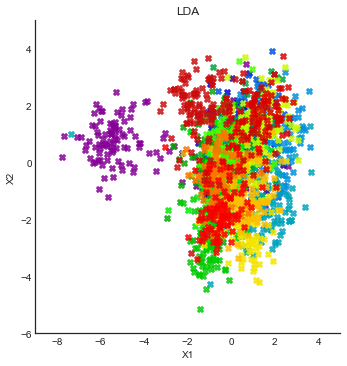

In [222]:
X1_lda, X2_lda = list(zip(*X_lda))
df_lda = pd.DataFrame(
    [X1_lda, X2_lda, y_sampled],
    index=["X1", "X2", "labels"]).T

lm = sns.lmplot(
    x="X1",
    y="X2",
    hue="labels",
    data=df_lda,
    fit_reg=False,
    legend=False,
    markers="X",
    palette="spectral", size=5)
lm.set(title=("LDA"), ylim=(-6,5), xlim=(-9, 5))
lm.savefig(dir_path +"/fig/lda.pdf")

## Analysis of misclassified test labels

In [206]:
df_test_samples = df_test.loc[index_test_samples]
df_test_samples['PRED'] = y_pred_test

In [207]:
from sklearn.metrics import confusion_matrix

breeds = np.unique(df_test_samples['BREED'].values)
y_test_breeds = [label2breed[invertlabel2class[i]] for i in y_test]
y_pred_test_breeds = [label2breed[invertlabel2class[i]] for i in y_pred_test]
cm = confusion_matrix(y_test_breeds, y_pred_test_breeds, labels=np.unique(breeds))

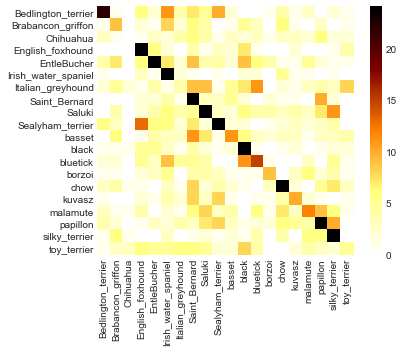

In [208]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = sns.heatmap(
    cm,
    ax=ax,
    robust=True,
    cmap=plt.cm.afmhot_r,
    yticklabels=breeds,
    xticklabels=breeds)
plt.tight_layout()
fig.savefig(dir_path +"/fig/cm1.pdf")

In [209]:
j = 0
for k, v in df_test_samples.iterrows():
    df_test_samples.loc[k,'PRED_BREED']=label2breed[invertlabel2class[y_pred_test[j]]]
    j+=1

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


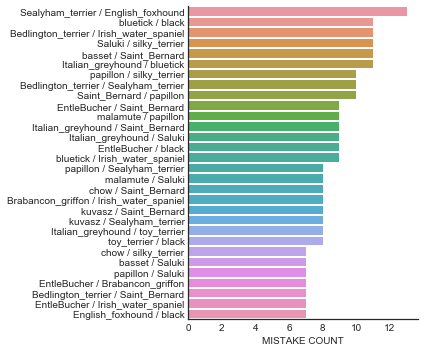

In [210]:
# misclass labels
misclass_df = df_test_samples[
    df_test_samples['BREED'] != df_test_samples['PRED_BREED']].groupby(
        ['BREED', 'PRED_BREED']).agg("count").sort_values(
            ['LABELS'], ascending=False).reset_index()
misclass_df['PAIR'] = misclass_df['BREED'] + ' / ' + misclass_df['PRED_BREED']
misclass_df = misclass_df[['PAIR', 'LABELS']].take(range(30))
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y=misclass_df['PAIR'], x=misclass_df['LABELS'], ax=ax)
ax.set_yticklabels(misclass_df['PAIR'])
ax.set_xlabel("MISTAKE COUNT")
ax.set_ylabel("")

sns.despine()
plt.tight_layout()
fig.savefig(dir_path +"/fig/mistake_count1.pdf")

## Other models

### Baseline model
DummyClassifier which classified the most frequent label

In [216]:
from sklearn.dummy import DummyClassifier

dummy = OneVsRestClassifier(DummyClassifier(strategy='prior'))
dummy.fit(X_train, y_train_c)

y_pred_train = dummy.predict(np.array(X_train))
y_pred_test = dummy.predict(np.array(X_test))
train_score_dummy = accuracy_score(y_train_c, y_pred_train)
test_score_dummy = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_dummy)
print('Overall accuracy (test):', test_score_dummy)

Overall accuracy (train): 0.05
Overall accuracy (test): 0.0688723835246455


### SVM with rbf kernel

In [217]:
from sklearn.svm import SVC

parameters = {'C': np.logspace(2, 7, 6)}

print("Training (Cross Validation)...")
if crossval:
    svc =  SVC(kernel='rbf', decision_function_shape="ovr")
    clf_svm_rbf = GridSearchCV(svc, parameters, scoring='accuracy')
else:
    clf_svm_rbf = SVC(C=1e4, kernel='rbf', decision_function_shape="ovr")

clf_svm_rbf.fit(X_train, y_train_c)

#print(clf_svm_rbf.best_params_)

print("Prediction...")
y_pred_train = clf_svm_rbf.predict(np.array(X_train))
y_pred_test = clf_svm_rbf.predict(np.array(X_test))
train_score_svm_rbf = accuracy_score(y_train_c, y_pred_train)
test_score_svm_rbf = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_svm_rbf)
print('Overall accuracy (test):', test_score_svm_rbf)

Training (Cross Validation)...
Prediction...
Overall accuracy (train): 1.0
Overall accuracy (test): 0.26603646185010127


### KNN classifier

In [238]:
from sklearn.neighbors import KNeighborsClassifier

params = {'estimator__n_neighbors' : np.arange(3,7)}
# classifier
if crossval:
    knn = OneVsRestClassifier(KNeighborsClassifier())
    clf_knn = GridSearchCV(knn, params, scoring='accuracy')
else:
    clf_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
    
clf_knn.fit(X_train, y_train_c)

#print(clf_knn.best_params_)

print("Prediction...")
y_pred_train = clf_knn.predict(np.array(X_train))
y_pred_test = clf_knn.predict(np.array(X_test))
train_score_knn = accuracy_score(y_train_c, y_pred_train)
test_score_knn = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_knn)
print('Overall accuracy (test):', test_score_knn)

Prediction...
Overall accuracy (train): 0.3615
Overall accuracy (test): 0.10668467251856853


### LogisticRegression

In [218]:
from sklearn.linear_model import LogisticRegressionCV

Cs =np.logspace(-7, 6, 14)
clf_lr = LogisticRegressionCV(Cs=Cs, dual=False, multi_class= "ovr",
                               scoring="accuracy")
    
clf_lr.fit(X_train, y_train_c)

print(clf_lr.C_)

print("Prediction...")
y_pred_train = clf_lr.predict(np.array(X_train))
y_pred_test = clf_lr.predict(np.array(X_test))
train_score_lr = accuracy_score(y_train_c, y_pred_train)
test_score_lr = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_lr)
print('Overall accuracy (test):', test_score_lr)

[1.e+03 1.e-07 1.e-07 1.e-07 1.e-07 1.e+02 1.e+06 1.e+05 1.e+01 1.e-07
 1.e-07 1.e-07 1.e-07 1.e+05 1.e+01 1.e+01 1.e-07 1.e+01 1.e-07 1.e+04]
Prediction...
Overall accuracy (train): 0.539
Overall accuracy (test): 0.1762322754895341


### Result Summary

In [239]:
models = ["DUMMY", "KNN", "LR", "SVM(LIN)", "SVM(RBF)"]
train_s = [
    train_score_dummy, train_score_knn, train_score_lr, train_score_svm,
    train_score_svm_rbf
]
test_s = [
    test_score_dummy, test_score_knn, test_score_lr, test_score_svm,
    test_score_svm_rbf
]
df_result = pd.DataFrame(
    list(zip(models, np.round(train_s, 2), np.round(test_s, 2))),
    columns=["MODEL", "TRAIN_SCORE", "TEST_SCORE"]).set_index("MODEL")


def color_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """

    color = 'green' if val > 0.25 else 'black'
    return 'color: %s' % color

df_result.style.applymap(color_green)

### Neural network
__NN-1__

In [48]:
from skimage.transform import resize

X_train_nn = []
for i, key in tqdm(enumerate(index_train_samples[index_op_sample])):
    img = imread("./images/" + df_train.loc[key].PATH)
    mat_img = np.array(img)
    X_train_nn.append(resize(mat_img, (224,224,3)))
    
X_test_nn = []

for i, key in tqdm(enumerate(index_test_samples)):
    img = imread("./images/" + df_test.loc[key].PATH)
    mat_img = np.array(img)
    X_test_nn.append(resize(mat_img, (224,224,3)))


0it [00:00, ?it/s]/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
2000it [00:36, 55.44it/s]
1481it [00:27, 53.18it/s]


In [49]:
from keras.models import load_model

#dir_path = os.getcwd()
#invertlabel2class = pickle.load(open(dir_path +'/db/invertlabel2class.p', "rb" ))
#label2breed = pickle.load(open(dir_path + '/db/label2breed.p', "rb"))

clf_VGG16 = load_model(dir_path + "/db/nn_model_base.h5")

clf_VGG16.summary()
print("Prediction...")
y_pred_train_nn1 = clf_VGG16.predict(np.array(X_train_nn))
y_pred_train_index_nn1 = [np.argsort(i)[::-1][0] for i in y_pred_train_nn1]

y_pred_test_nn1 = clf_VGG16.predict(np.array(X_test_nn))
y_pred_test_index_nn1 = [np.argsort(i)[::-1][0] for i in y_pred_test_nn1]

train_score_nn1 = accuracy_score(y_train_c, y_pred_train_index_nn1)
test_score_nn1 = accuracy_score(y_test, y_pred_test_index_nn1)

print('Overall accuracy (train):', train_score_nn1)
print('Overall accuracy (test):', test_score_nn1)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [50]:
clf_VGG16T = load_model(dir_path + "/db/nn_model_2.h5")

clf_VGG16T.summary()
print("Prediction...")
y_pred_train_nn2 = clf_VGG16T.predict(np.array(X_train_nn))
y_pred_train_index_nn2 = [np.argsort(i)[::-1][0] for i in y_pred_train_nn2]

y_pred_test_nn2 = clf_VGG16T.predict(np.array(X_test_nn))
y_pred_test_index_nn2 = [np.argsort(i)[::-1][0] for i in y_pred_test_nn2]

train_score_nn2 = accuracy_score(y_train_c, y_pred_train_index_nn2)
test_score_nn2 = accuracy_score(y_test, y_pred_test_index_nn2)

print('Overall accuracy (train):', train_score_nn2)
print('Overall accuracy (test):', test_score_nn2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
clf_xception = load_model(dir_path + "/db/nn_xception.h5")

clf_xception.summary()
print("Prediction...")
y_pred_train_nn3 =  clf_xception.predict(np.array(X_train_nn))
y_pred_train_index_nn3 = [np.argsort(i)[::-1][0] for i in y_pred_train_nn3]

y_pred_test_nn3 =  clf_xception.predict(np.array(X_test_nn))
y_pred_test_index_nn3 = [np.argsort(i)[::-1][0] for i in y_pred_test_nn3]

train_score_nn3 = accuracy_score(y_train_c, y_pred_train_index_nn3)
test_score_nn3 = accuracy_score(y_test, y_pred_test_index_nn3)

print('Overall accuracy (train):', train_score_nn3)
print('Overall accuracy (test):', test_score_nn3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Overall accuracy (train): 0.982
Overall accuracy (test): 0.9182984469952734


In [233]:
df_test_samples['PRED_NN'] = y_pred_test_index_nn3
y_test_breeds_nn3 = [label2breed[invertlabel2class[i]] for i in y_test]
y_pred_test_breeds_nn3 = [label2breed[invertlabel2class[i]] for i in y_pred_test_index_nn3]
cm_nn = confusion_matrix(y_test_breeds_nn3, y_pred_test_breeds_nn3, labels=np.unique(breeds))

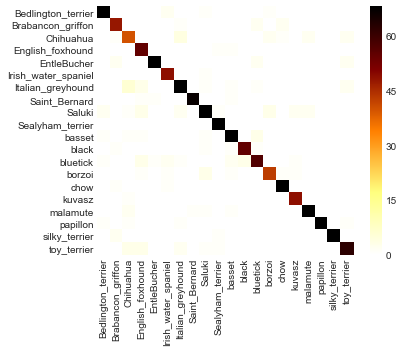

In [235]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = sns.heatmap(
    cm_nn,
    ax=ax,
    robust=True,
    cmap=plt.cm.afmhot_r,
    yticklabels=breeds,
    xticklabels=breeds)
plt.tight_layout()
fig.savefig(dir_path +"/fig/cm_nn.pdf")

In [236]:
j = 0
for k, v in df_test_samples.iterrows():
    df_test_samples.loc[k,'PRED_BREED_NN']=label2breed[invertlabel2class[y_pred_test_index_nn3[j]]]
    j+=1

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


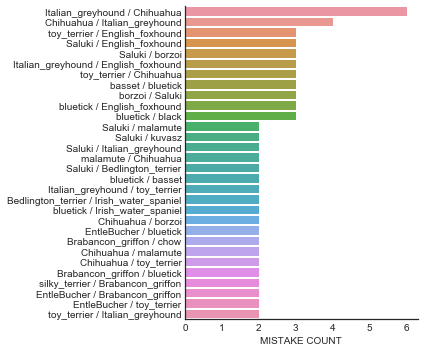

In [237]:
# misclass labels
misclass_df = df_test_samples[
    df_test_samples['BREED'] != df_test_samples['PRED_BREED_NN']].groupby(
        ['BREED', 'PRED_BREED_NN']).agg("count").sort_values(
            ['LABELS'], ascending=False).reset_index()
misclass_df['PAIR'] = misclass_df['BREED'] + ' / ' + misclass_df['PRED_BREED_NN']
misclass_df = misclass_df[['PAIR', 'LABELS']].take(range(30))
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y=misclass_df['PAIR'], x=misclass_df['LABELS'], ax=ax)
ax.set_yticklabels(misclass_df['PAIR'])
ax.set_xlabel("MISTAKE COUNT")
ax.set_ylabel("")

sns.despine()
plt.tight_layout()
fig.savefig(dir_path +"/fig/mistake_count_nn.pdf")

## Top k accuracy

In [196]:
clf_list = [clf_svm, clf_svm_rbf, clf_lr, clf_knn, dummy, clf_VGG16, clf_VGG16T, clf_xception]
clf_labels = ["SVM(LIN)", "SVM(RBF)", "LR", "KNN", "DUMMY", "VGG16", "VGG16(T)", "XCEPTION"]
k_score = [[] for i in range(len(clf_list))]
k_list = np.arange(1, 8)

for i, clf in enumerate(clf_list):
    print(i)
    if i >4:
        y_pred_proba = clf.predict(np.array(X_test_nn))
    elif (i==0 or i > 2):
        y_pred_proba = clf.predict_proba(np.array(X_test))
    else:
        y_pred_proba = clf.decision_function(np.array(X_test))
    for k in k_list:
        score = top_k_accuracy(y_pred_proba, y_test, np.arange(20), k=k)
        k_score[i].append(score)

0
1
2
3
4
5
6
7


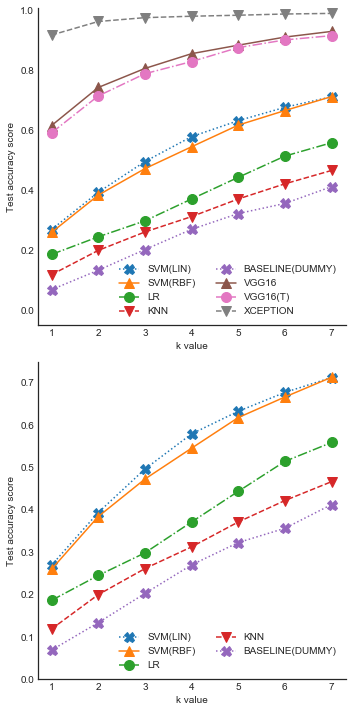

In [244]:
fig, axes = plt.subplots(2,1, figsize=(5,10))
ax = axes.flatten()
markers = ["X","^","o","v"]
linestyles = [":","-","-.","--"]
clf_labels = ["SVM(LIN)", "SVM(RBF)", "LR", "KNN", "BASELINE(DUMMY)", "VGG16", "VGG16(T)", "XCEPTION"]


for i, clf in enumerate(clf_list):
    ax[0].plot(k_list, k_score[i], marker=markers[i%4], linestyle=linestyles[i%4],
            markersize=10, label=clf_labels[i])
    if i<5:
        ax[1].plot(k_list, k_score[i], marker=markers[i%4], linestyle=linestyles[i%4],
            markersize=10, label=clf_labels[i])
ax[0].legend(loc='best', ncol=2)
ax[0].set_xlabel("k value")
ax[0].set_ylabel("Test accuracy score")
ax[0].set_ylim(-0.05,1.01)
ax[1].legend(loc='best', ncol=2)
ax[1].set_xlabel("k value")
ax[1].set_ylabel("Test accuracy score")
ax[1].set_ylim(0,.75)
sns.despine()
plt.tight_layout()
fig.savefig(dir_path +"/fig/result_top_k.pdf")

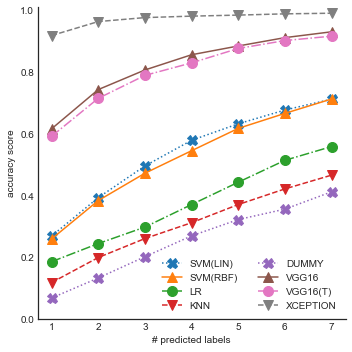

In [197]:
fig, ax = plt.subplots(figsize=(5, 5))
markers = ["X","^","o","v"]
linestyles = [":","-","-.","--"]
for i, clf in enumerate(clf_list):
    ax.plot(k_list, k_score[i], marker=markers[i%4], linestyle=linestyles[i%4],
            markersize=10, label=clf_labels[i])
ax.legend(loc='best', ncol=2)
ax.set_xlabel("# predicted labels")
ax.set_ylabel("accuracy score")
ax.set_ylim(0,1.01)
sns.despine()
plt.tight_layout()

# Result summary

In [245]:
models = ["BASELINE(DUMMY)", "KNN", "LR", "SVM(LIN)", "SVM(RBF)", "VGG16", "VGG16(T)", "XCEPTION"]
train_s = [
    train_score_dummy, train_score_knn, train_score_lr, train_score_svm,
    train_score_svm_rbf, train_score_nn1,train_score_nn2, train_score_nn3
]
test_s = [
    test_score_dummy, test_score_knn, test_score_lr, test_score_svm,
    test_score_svm_rbf, test_score_nn1,test_score_nn2, test_score_nn3
]
df_result = pd.DataFrame(
    list(zip(models, np.round(train_s,2), np.round(test_s,2))),
    columns=["MODEL", "TRAIN_SCORE", "TEST_SCORE"]).set_index("MODEL")

def color_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'green' if val > 0.3 else 'black'
    return 'color: %s' % color

df_result.style.applymap(color_green)